In [1]:
from supervised.automl import BaseAutoML, AutoML

from prophet import Prophet

import pandas as pd

import math

In [2]:
train_df=pd.read_csv('./data/train.csv')
test_df=pd.read_csv('./data/test.csv')

In [3]:
df=train_df[['date','rental']].copy()
df.columns=['ds','y']
m = Prophet()
m.daily_seasonality=True
m.weekly_seasonality=True
m.yearly_seasonality=True
m.fit(df)
future=m.make_future_dataframe(365)
forecast = m.predict(future)

Initial log joint probability = -73.9282
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1699.14   5.17586e-06       69.4858      0.7698      0.7698      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       1699.17   0.000410967       93.1272   3.446e-06       0.001      181  LS failed, Hessian reset 
     150       1699.19   3.83621e-05       77.7678   4.552e-07       0.001      266  LS failed, Hessian reset 
     177       1699.19    1.5188e-07       69.0376      0.2292           1      304   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [4]:
train_df['rental']=train_df['rental']/forecast[:-365]['trend']

In [5]:
train_df['date']=pd.to_datetime(train_df['date'])
train_df['year']=train_df['date'].dt.year
train_df['month']=train_df['date'].dt.month
train_df['day']=train_df['date'].dt.day
train_df = train_df[['date', 'precipitation', 'temp_mean', 'temp_highest', 'temp_lowest',
       'PM10', 'PM2.5', 'humidity', 'sunshine_sum', 'sunshine_rate',
       'wind_mean', 'wind_max', 'year', 'month', 'day', 'rental']]

In [6]:
test_df['date']=pd.to_datetime(test_df['date'])
test_df['year']=test_df['date'].dt.year
test_df['month']=test_df['date'].dt.month
test_df['day']=test_df['date'].dt.day

In [7]:
# 옵션에 따라, 선택한 데이터프레임의 컬럼의 결측값을 채워주는 함수
# option = 0, min, max, mean, median
def cal(my_df, column_name, option):
    df=my_df.copy()
    df['date']=pd.to_datetime(df['date'])
    df['month']=df['date'].dt.month
    nn_df = df.iloc[df[column_name].dropna().index]
    month_df_list=[nn_df[nn_df['month']==i] for i in range(1,13)]
    
    if option == 0:
        replace_list=[0 for month_df in month_df_list]
    elif option =='min':
        replace_list=[month_df[column_name].min() for month_df in month_df_list]
    elif option =='max':
        replace_list=[month_df[column_name].max() for month_df in month_df_list]
    elif option == 'mean':
        replace_list=[month_df[column_name].mean() for month_df in month_df_list]
    elif option == 'median':
        replace_list=[month_df[column_name].median() for month_df in month_df_list]
    
    replace_list = ['']+ replace_list
    
    result=[]
    for i in range(my_df.shape[0]):
        n=my_df.iloc[i][column_name]
        if math.isnan(n):
            result.append(replace_list[df.loc[i]['month']])
        else:
            result.append(n)
    my_df[column_name] = result

In [8]:
null_feature = ['precipitation','PM10','PM2.5','sunshine_sum']
best_option_group = ['min' , 'max' , 'median' , 'min']
for column_name, option in zip(null_feature, best_option_group):
    cal(train_df, column_name, option)
for column_name, option in zip(null_feature, best_option_group):
    cal(test_df, column_name, option)

In [9]:
X_train, y_train = train_df.iloc[:,1:-1].to_numpy(), train_df.iloc[:,-1].to_numpy()
X_test = test_df.iloc[:,1:].to_numpy()

In [10]:
automl = AutoML(mode="Compete", n_jobs=-1, results_path='./결과내기_compete')
automl.fit(X_train, y_train)

AutoML directory: ./결과내기_compete
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Decision Tree', 'Linear', 'Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network', 'Nearest Neighbors']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree rmse 0.452035 trained in 0.28 seconds
Adjust validation. Remove: 1_DecisionTree
Validation strategy: 10-fold CV Shuffle
* Step simple_algorithms will try to check up to 4 models
1_DecisionTree rmse 0.405521 trained in 1.26 seconds
2_DecisionTree rmse 0.364658 trained in 1.09 seconds
3_DecisionTree rmse 0.364705 trained in 1.34 seconds
4_L

101_ExtraTrees rmse 0.259512 trained in 10.0 seconds
102_NearestNeighbors rmse 0.309933 trained in 7.36 seconds
103_NearestNeighbors rmse 0.309933 trained in 7.42 seconds
104_DecisionTree rmse 0.364705 trained in 7.04 seconds
105_DecisionTree rmse 0.364658 trained in 7.09 seconds
106_DecisionTree rmse 0.405521 trained in 7.18 seconds
* Step hill_climbing_2 will try to check up to 12 models
107_CatBoost_GoldenFeatures_SelectedFeatures rmse 0.213091 trained in 11.57 seconds
108_CatBoost_GoldenFeatures_SelectedFeatures rmse 0.221286 trained in 8.84 seconds
109_CatBoost_GoldenFeatures rmse 0.212243 trained in 12.35 seconds
110_CatBoost_GoldenFeatures rmse 0.217541 trained in 9.34 seconds
111_CatBoost_GoldenFeatures rmse 0.213071 trained in 11.38 seconds
112_CatBoost_GoldenFeatures rmse 0.217628 trained in 9.16 seconds
113_Xgboost_GoldenFeatures rmse 0.21507 trained in 22.98 seconds
114_Xgboost_GoldenFeatures rmse 0.215955 trained in 25.96 seconds
115_LightGBM_SelectedFeatures rmse 0.224188

AutoML(mode='Compete', results_path='./결과내기_compete')

In [11]:
model=AutoML(results_path='./결과내기_compete')

In [12]:
my_result_df = pd.DataFrame()

In [13]:
my_result_df['date'] = test_df['date']

In [14]:
my_result_df['rental']=list( forecast[-365:]['trend'] * model.predict(X_test))

X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted 

X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted 

X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted 

In [15]:
my_result_df.set_index('date', inplace=True)

In [16]:
my_result_df

,rental
date,
2021-01-01,30569.932846
2021-01-02,27180.574445
2021-01-03,24608.291338
2021-01-04,30855.289002
2021-01-05,25991.449293
...,...
2021-12-27,29644.226371
2021-12-28,33841.874735
2021-12-29,42969.317284


In [17]:
my_result_df.to_csv('./final_compete.csv')

<AxesSubplot:xlabel='date'>

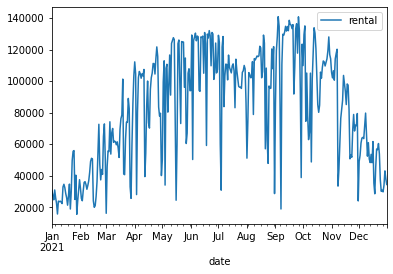

In [18]:
my_result_df.plot()